## Student Name:
 Gerard Carmody
 
 ## Student Number:
  22218068

## Task 2

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from scipy import interp
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

%matplotlib inline

### EDA - Exploratory Data Analysis

In [2]:
df = pd.read_csv("./seeds.csv")
df.head()

area  perimeter  compactness  length of kernel  width of kernel  \
0  15.26      14.84       0.8710             5.763            3.312   
1  14.88      14.57       0.8811             5.554            3.333   
2  14.29      14.09       0.9050             5.291            3.337   
3  13.84      13.94       0.8955             5.324            3.379   
4  16.14      14.99       0.9034             5.658            3.562   

   asymmetry coefficient  length of kernel groove  type  
0                  2.221                    5.220     1  
1                  1.018                    4.956     1  
2                  2.699                    4.825     1  
3                  2.259                    4.805     1  
4                  1.355                    5.175     1

In [3]:
df.tail()

area  perimeter  compactness  length of kernel  width of kernel  \
205  12.19      13.20       0.8783             5.137            2.981   
206  11.23      12.88       0.8511             5.140            2.795   
207  13.20      13.66       0.8883             5.236            3.232   
208  11.84      13.21       0.8521             5.175            2.836   
209  12.30      13.34       0.8684             5.243            2.974   

     asymmetry coefficient  length of kernel groove  type  
205                  3.631                    4.870     3  
206                  4.325                    5.003     3  
207                  8.315                    5.056     3  
208                  3.598                    5.044     3  
209                  5.637                    5.063     3

In [4]:
#display data shape
df.shape

(210, 8)

In [5]:
#70 of each type
df['type'].value_counts()

1    70
2    70
3    70
Name: type, dtype: int64

In [6]:
#no data missing
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

In [7]:
#create list of columns
cols = list(df.columns.values)

#drop type from list
cols.pop(-1)

#display list of predictor cols
cols

['area',
 'perimeter',
 'compactness',
 'length of kernel',
 'width of kernel',
 'asymmetry coefficient',
 'length of kernel groove']

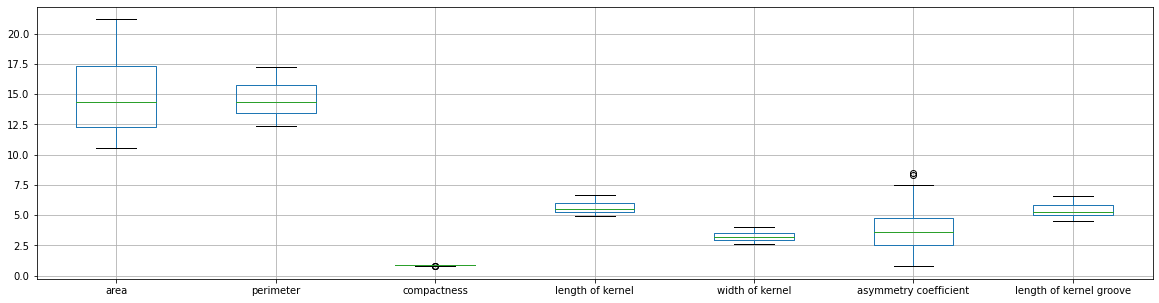

In [8]:
#boxplot of features
df.boxplot(column= cols, figsize=(20,5))
plt.show()

#### We can see from the boxplot that asymmetry coefficient has outliers

## Merge vlues 1 and 3 in type to facilitate binary classification

In [9]:
#store original data
original_data = df.copy()

In [10]:
df['type'].value_counts()

1    70
2    70
3    70
Name: type, dtype: int64

In [11]:
#set 2 = 0 and merge 1 and 3 to create a binary output type
df['type'].replace({1:1, 2: 0, 3: 1}, inplace= True)
df['type'].value_counts()

1    140
0     70
Name: type, dtype: int64

#### Analysis

We started with 3 different wheat kernels, Kama, Rosa and Canadian. I have merged Canadian and Kama. I will create a model to try and correctly classify Rosa or (other 2).

### Data Preperation

In [12]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['type']]

# define column groups with same data preparation
names_outliers = ['asymmetry coefficient']
names_no_outliers = list(set(names_all) - set(names_outliers))

In [13]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

In [14]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

In [15]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns= names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

In [16]:
y = df['type']
X = df.drop('type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

## Grid Search for Best Parameters of Classifiers

In [17]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) #trainign happens here! SVM is trained 240 times

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.982:
Best parameters:  {'svm__C': 10, 'svm__gamma': 1, 'svm__kernel': 'rbf'}


In [18]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.976:
Best parameters:  {'rf__max_depth': 2, 'rf__n_estimators': 10}


In [19]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [20]:
# model - a trained ternary probabilistic classification model;
#         it is assumed that there are 2 classes.
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [21]:
def evaluate_model_for_precision_recall_curve(X_test, y_test, model):
    """
    Computes various evaluation metrics for a binary classification model, including accuracy, precision, recall, f1 score, 
    true positive rate, and area under the curve (AUC) for the precision-recall curve.
    
    Parameters:
    -----------
    X_test: array-like or sparse matrix, shape (n_samples, n_features)
        Test samples.
    y_test: array-like, shape (n_samples,)
        True labels for X_test.
    model: object
        Fitted binary classification model with a `predict` and `predict_proba` method.

    
        Returns:
    --------
    accuracy: float
        Accuracy score of the model on the test set.
    precision: array, shape (n_thresholds,)
        Precision values for different threshold levels.
    recall: array, shape (n_thresholds,)
        Recall values for different threshold levels.
    f1_score: float
        F1 score of the model for class 1.
    tpr_transformed: array, shape (1, n_mean_recall)
        True positive rates for different threshold levels transformed to have the same length as `mean_recall`.
    auc: float
        Area under the curve for the precision-recall curve.
    """ 
    
    #compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    mean_recall = np.linspace(0, 1, 100)
    
    #compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    #compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    #compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    #compute precision and recall values for different threshold levels
    _precision, _recall, _thresholds = precision_recall_curve(y_test, _probabilities)

    m_precision, m_recall, _ = precision_recall_curve(y_test, _predicted_values)
    
    #compute true positive rates for the values in the array mean_recall
    _tpr_transformed = np.array([np.interp(mean_recall, _recall[::-1], _precision[::-1])])
    
    #compute the area under the curve
    _auc = auc(_recall, _precision)
            
    return _accuracy, m_precision, m_recall, _f1_score[0], _tpr_transformed, _auc

In [22]:
#evalulate SVM model
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)

#evalulate RF model
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)

                SVM  Random Forest
accuracy   0.928571       0.952381
precision  0.962963       1.000000
recall     0.928571       0.928571
F1-score   0.945455       0.962963


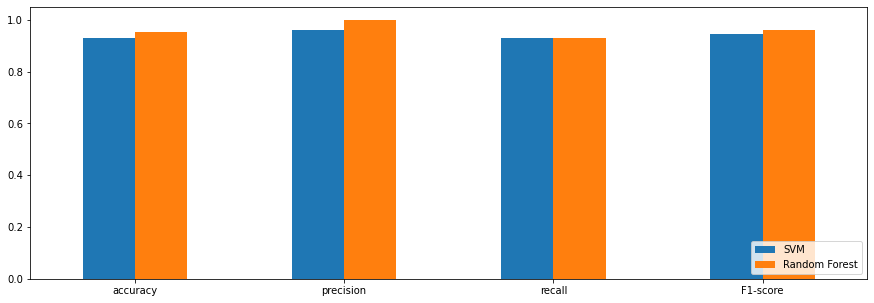

In [23]:
#store metrics in a dataframe
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)

#display metrics
print(df_metrics)

#plot bar chart of metrics
df_metrics.plot.bar(figsize=(15, 5),rot=0)
plt.legend(loc="lower right")
plt.show()

### Analysis Bar Chart

The bar chart above shows very strong performance of both SVM and RF. 

However, RF has a higher precision, accuracy and F1 score with recall matched in both.

These metrics would suggest RF is a better model for this data.

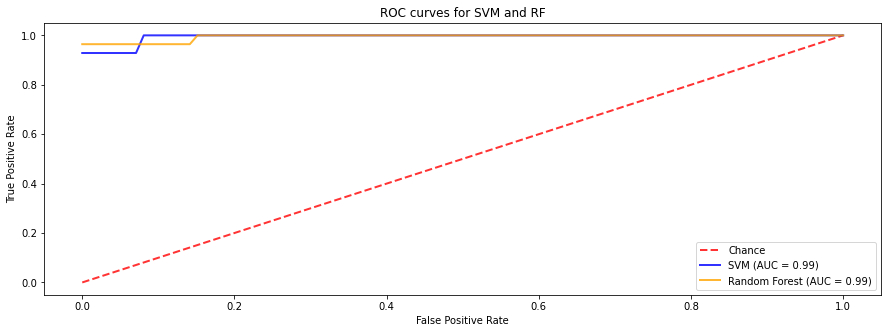

In [24]:
#select plot size
plt.figure(figsize=(15, 5))

#plot ROC Curve
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for SVM and RF')
plt.legend(loc="lower right")
plt.show()

### Analysis ROC Curve

The ROC curve shows both SVM and RF have an area under the curve of 0.99.

The RF is closer to the top left corner, closer to having a sensitivity of 1.

This graph suggests RF is a better model for this data. However, I will use a PR curve for validation as a PR curve is better for unbalanced data.

In [25]:
#evalulate SVM model for PR Curve
SVM_accuracy_PR, SVM_precision_PR, SVM_recall_PR, SVM_f1_score_PR, SVM_tpr_PR, SVM_auc_PR = evaluate_model_for_precision_recall_curve(X_test, y_test, SVM_best_model)

#evalulate RF model for PR Curve
RF_accuracy_PR, RF_precision_PR, RF_recall_PR, RF_f1_score_PR, RF_tpr_PR, RF_auc_PR = evaluate_model_for_precision_recall_curve(X_test, y_test, RF_best_model)

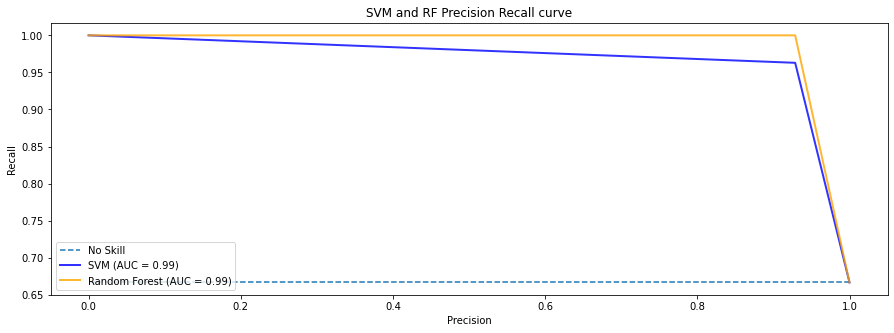

In [26]:
#set figure size
plt.figure(figsize=(15, 5))

#plot PR Curve
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(SVM_recall_PR, SVM_precision_PR, lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(RF_recall_PR, RF_precision_PR, lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('SVM and RF Precision Recall curve')
plt.legend(loc="lower left")
plt.show()

### Analysis PR Curve

The PR Curve clearly shows RF as the better model, In this graph we are looking for the curve closer to the top right hand corner. The curve closest to a recall and precision of 1.

### Support Vector Machines (SVM)

SVM is an algorithm that finds the best hyperplane to separate different classes in a feature space. The hyperplane maximises the margin between the classes, and the closest data points to the hyperplane are called support vectors. SVM uses a kernel trick to transform the feature space to a higher dimensional space to make the classes separable if they are not linearly separable. SVM can handle high-dimensional data and is less affected by the curse of dimensionality. 

### Random Forrest (RF)

Random Forest is an algorithm that builds multiple decision trees and aggregates their predictions to make the final prediction for classification and regression tasks. Each decision tree is built on a random subset of the training data and features to reduce overfitting. The trees are built by recursively partitioning the feature space into smaller regions. The predictions are combined through either majority voting or weighted averaging. Random Forest can also provide feature importance scores.

## Task 3, Add KNN

In [27]:
from sklearn.neighbors import KNeighborsClassifier

In [28]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('knn',  KNeighborsClassifier())])

# prepare a prameter grid

param_grid = {
    
    #the number of nearest neighbors to consider when making a prediction.
    'knn__n_neighbors': [3, 4, 5, 6, 7, 8, 9],
    
    # the weight function used in predictions
    #uniform: all points in each neighborhood are weighted equally
    #distance: where closer neighbors of a query point will have a greater influence than ones further away
    'knn__weights': ['uniform', 'distance'],
    
    # try Minkowski metric, Manhattan distance and Euclidean distance
    'knn__p': [1, 2, 3]
}

# 5 fold cross validation
# use best hyperparameters
# use all available cpu cores
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) 

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best parameters and best model for later use
KNN_best_params = search.best_params_
KNN_best_model = search.best_estimator_

Best CV score = 0.982:
Best parameters:  {'knn__n_neighbors': 3, 'knn__p': 3, 'knn__weights': 'distance'}


In [29]:
#evaluate KNN
KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score, KNN_tpr, KNN_auc = evaluate_model(X_test, y_test, KNN_best_model)

                SVM  Random Forest       KNN
accuracy   0.928571       0.952381  0.928571
precision  0.962963       1.000000  1.000000
recall     0.928571       0.928571  0.892857
F1-score   0.945455       0.962963  0.943396


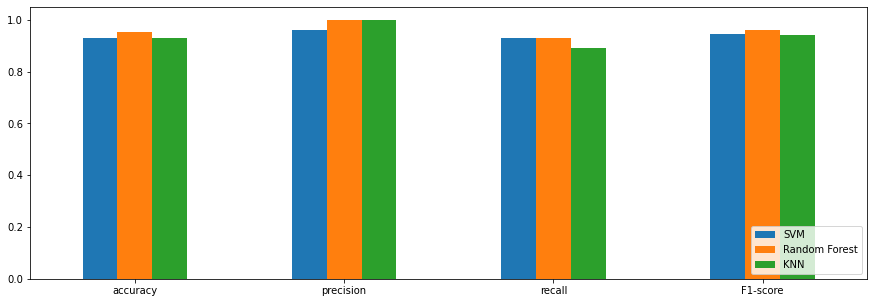

In [35]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
KNN_metrics = np.array([KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'KNN': KNN_metrics}, index=index)

print(df_metrics)

df_metrics.plot.bar(figsize=(15, 5), rot=0)
plt.legend(loc="lower right")
plt.show()

### Analysis Bar Chart

We can see that KNN has performed very well. However, RF appears to still be the best model for this data.

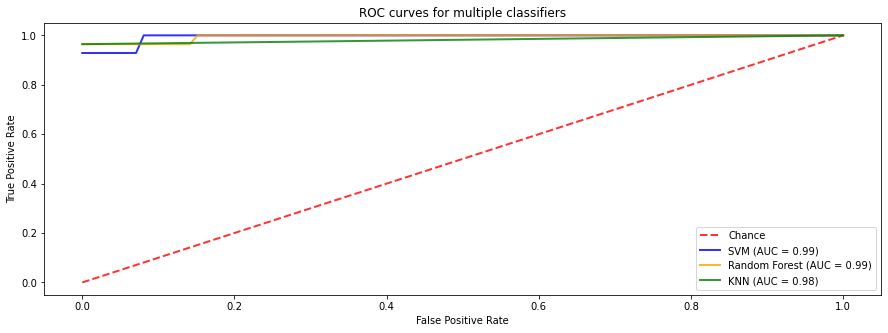

In [34]:
#select plot size
plt.figure(figsize=(15, 5))

#plot ROC Curve
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, KNN_tpr[0,:], lw=2, color='green', label='KNN (AUC = %0.2f)' % (KNN_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

### Analysis ROC Curve

KNN has the lowest area under the curve at 0.98.

However, the graph shows KNN to be a better choice than SVM.

In [32]:
#evaluate KNN for PR Curve
KNN_accuracy_PR, KNN_precision_PR, KNN_recall_PR, KNN_f1_score_PR, KNN_tpr_PR, KNN_auc_PR = evaluate_model_for_precision_recall_curve(X_test, y_test, KNN_best_model)

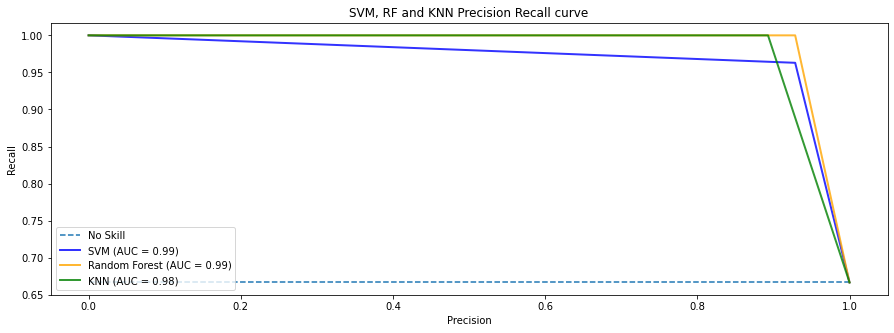

In [33]:
plt.figure(figsize=(15, 5))

#plot PR Curve
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(SVM_recall_PR, SVM_precision_PR, lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(RF_recall_PR, RF_precision_PR, lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(KNN_recall_PR, KNN_precision_PR, lw=2, color='green', label='KNN (AUC = %0.2f)' % (KNN_auc), alpha=0.8)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('SVM, RF and KNN Precision Recall curve')
plt.legend(loc="lower left")
plt.show()

In [36]:
df_metrics

SVM  Random Forest       KNN
accuracy   0.928571       0.952381  0.928571
precision  0.962963       1.000000  1.000000
recall     0.928571       0.928571  0.892857
F1-score   0.945455       0.962963  0.943396

### Analysis PR Curve

The Precision recall curve above clearly shows RF as the best model for this data as it is the curve closest to the top right corner indicating that it is the closest to a precision and recall of 1. This can also be clearlt seen in the metrics displayed above. RF has the highest score for accuracy, precision, recall and F1 score.

### KNN

KNN is an algorithm that works by finding the K closest data points in the training set to the test point and predicting the most common class among those K points. It works well for datasets with a small number of features. However, KNN can be computationally expensive and requires careful selection of the value of K.

### Conclusion

##### Random Forrest is the model that performed best for me on the data set.

In binary classification, there is a trade-off between precision and recall. 

Precision is the proportion of true positive predictions among all positive predictions, which means it measures how many of the predicted positives are actually positive. High precision means that the classifier is very selective and doesn't make many false positive predictions, but it may miss some true positive predictions, resulting in a low recall.

Recall is the proportion of true positive predictions among all actual positive instances, which means it measures how many of the actual positives are correctly predicted. High recall means that the classifier is very sensitive and doesn't miss many true positive predictions, but it may also make many false positive predictions, resulting in low precision.

For example, in a security situation, using biometrics to allow a person access to a classified computer. We will never want to allow a false positive as the consequences are a security breach while a false negative will just mean the person must rescan fingerprint etc. In this case, we would want a high-precision model.

An alternative model classifying a cancer diagnosis would require a high-recall model would be preferred over a high-precision model. This is because a false negative, where the model incorrectly identifies a cancer patient as not having cancer, could have fatal consequences.

In this case, we are trying to correctly identify Rosa wheat kernels so a high-precision model is preferred. In this case, the random forest and KNN both have a precision of 1. I have selected Rf because it also has accuracy, recall and F1 score. 


## Train a Final Model

In [37]:
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(SVM_best_params)))

final_model =pipe.fit(X, y)

In [38]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))